# A peak into IceNet validation commands
- Ryan Chan (Research Software Engineer, The Alan Turing Institute)
- Oliver Strickson (Senior Research Software Engineer, The Alan Turing Institute)
- James Byrne (Research Software Engineer, British Antarctic Survey)
- Tom Andersson (Data Scientist, British Antarctic Survey)

## Summary
This notebook illustrates the command line interface (CLI) utilitities that are available natively from the [IceNet library](https://github.com/icenet-ai/icenet) which can be used to compute metrics and create plots for evaluation of sea-ice concentration (SIC) forecasts.

In this notebook, we will illustrate how to compute and plot metrics for validating IceNet forecasts using the IceNet library Pythonically (i.e. using the functions in Python) and how to use the CLI commands which essentially creates a wrapper around the relevant IceNet functions to produce and save plots.

We note that this notebook is not a proper evaluation of IceNet as a model, but the main purpose is to illustrate how we can use the validation commands in the IceNet library to evaluate forecasts made by the model.

## Prerequistes
In order to run this notebook, we assume that you have a working IceNet environment and pipeline (the details of which can be found in the [`icenet-pipeline` repository](https://github.com/icenet-ai/icenet-pipeline) which illustrates the operational execution of the IceNet model). Furthermore, as the focus of the notebook is to illustrate commands to _validate_ (or _evaluate_) sea-ice concentration forecasts (made with IceNet or otherwise), we will also assume that the user has created forecasts (stored in NetCDF files, i.e. files with `.nc` extension). For details on how to make forecasts with IceNet, please see notebooks [1](https://github.com/icenet-ai/icenet-notebooks/blob/main/01.cli_demonstration.ipynb), [2](https://github.com/icenet-ai/icenet-notebooks/blob/main/02.data_and_forecasts.ipynb) and [3](https://github.com/icenet-ai/icenet-notebooks/blob/main/03.library_usage.ipynb) in the [`icenet-notebooks` repository](https://github.com/icenet-ai/icenet-notebooks).

## References
Andersson, T.R., Hosking, J.S., Pérez-Ortiz, M. et al. Seasonal Arctic sea ice forecasting with probabilistic deep learning. Nat Commun 12, 5124 (2021). https://doi.org/10.1038/s41467-021-25257-4

In [74]:
import os
import numpy as np 
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import timedelta

# Import some useful IceNet functions
from icenet.data.sic.mask import Masks
from icenet.plotting.utils import (get_obs_da,
                                   get_forecast_ds,
                                   filter_ds_by_obs,
                                   get_seas_forecast_da)

# Import core functions to compute and plot various metrics
from icenet.plotting.forecast import (sic_error_video,
                                      process_probes,
                                      sic_error_local_plots,
                                      compute_metrics,
                                      compute_binary_accuracy,
                                      compute_sea_ice_extent_error,
                                      compute_metrics_leadtime_avg,
                                      plot_metrics,
                                      plot_binary_accuracy,
                                      plot_sea_ice_extent_error,
                                      plot_metrics_leadtime_avg)

# Allows us to display images that we will save as .png files
from IPython.display import Image

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

%matplotlib inline

As noted above in the prerequistes, we assume that you have a working IceNet environment and have a directory structure like the one in the [`icenet-pipeline` repository](https://github.com/icenet-ai/icenet-pipeline), to run this notebook, change the below cell to the appropriate path for your machine.

In [2]:
# change to the path of your own IceNet directory
os.chdir("/data/hpcdata/users/rychan/icenet/")

In this working directory, there should be a `data/` folder which stores some IceNet data (or is a symlink to it).

In [3]:
# data/ should exist in your IceNet directory and should store IceNet data
os.listdir("./data/")

['osisaf',
 'era5',
 'masks',
 'mars.hres',
 'cmip6.MRI-ESM2-0.r1i1p1f1',
 'oras5',
 'mars.seas']

Furthermore, we assume that the forecasts are stored in a NetCDF (`.nc`) file. For this particular notebook, we have trained a model where the training dataset is data from **1990-01-01** to  **2013-12-31**.

After training, we initialise the model every single day between **2018-01-01** and **2020-12-31** to predict the next 93 days from the initialisation date, and we're just focusing on the Northern hemisphere. In particular, for each day between **2018-01-01** and **2020-12-31**, we make a daily SIC forecast for next 93 days.

But of course, the forecasts made in your forecast file and the model that you used to make those forecasts may well be different. To run this notebook for your forecasts, change the below cell to the appropriate path for your machine.

In [ ]:
# change to the path for your own forecast file
forecast_file = "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc"
fc_ds = xr.open_dataset(forecast_file)
fc_ds

# Computing and plotting metrics for a forecasts from a particular date of interest

After loading in forecast file, we obtain an `xarray.Dataset` object where we have forecasts initialised at each date between  **2018-01-01** and **2020-12-31**, and for each of those dates, we have a forecast of the SIC for each grid location at each leadtime $(1, 2, ..., 93)$.

In this section, we look at how we can compute metrics to evaluate a forecast for a particular day of interest.

For the purposes of this section, we focus on the forecasts made after initiailising the model from **2020-03-01** (so we're predicting dates between **2020-03-02** to **2020-06-02** (the initialisation date + 93 leadtime days)).

### Setup for evaluating forecasts initialised at some date of interest

- IceNet relies on some generated masks which we assume are in the `data/` repository (see [Notebook 1](https://github.com/icenet-ai/icenet-notebooks/blob/main/01.cli_demonstration.ipynb) in the [`icenet-notebooks` repository](https://github.com/icenet-ai/icenet-notebooks) for more details on how to automatically generate masks for training/prediction using the `icenet_data_masks` CLI command).
- We use the `get_forecast_ds` function from the IceNet library to obtain our `xarray.Dataset` object which stores our forecasts from the NetCDF forecast file for our particular date of interest.
- We use the `get_obs_da` function from the IceNet library to obtain our `xarray.DataArray` object which stores the model's ground truth (OSISAF data) for the days we're forecasting for.
- We then need to filter our Forecast `xarray.Dataset` object to obtain the `xarray.DataArray` object for which we can compare with and compute metrics for.
- We will store our produced plots in the `plot/` directory which will be created if it does not exist in our current working directory (and similarly we will save some metrics computed in the `metrics/` directory).

In [83]:
date_of_interest = pd.Timestamp("2020-03-01")
masks = Masks(north=True)
fc = get_forecast_ds(forecast_file=forecast_file,
                     forecast_date=date_of_interest)
obs = get_obs_da(hemisphere="north",
                 start_date=pd.to_datetime(date_of_interest) + timedelta(days=1),
                 end_date=pd.to_datetime(date_of_interest) + timedelta(days=int(fc.leadtime.max())))
fc = filter_ds_by_obs(fc, obs, date_of_interest)

if not os.path.exists("plot/"):
    os.makedirs("plot/")

if not os.path.exists("metrics/"):
    os.makedirs("metrics/")

INFO:root:Got files: ['./data/osisaf/north/siconca/2020.nc']
INFO:root:Starting index will be 0 for 2020-03-02 00:00:00 - 2020-06-02 00:00:00


### SIC error animations

We can get an animation highlighting the the SIC error of the forecast using the `sic_error_video` function in the IceNet library. This generates an MP4 file which shows the IceNet SIC prediction on the left, the "ground truth" SIC from OSISAF in the middle and the difference (i.e. the error of the prediction) in the right.

In [72]:
sic_error_video(fc_da=fc,
                obs_da=obs,
                land_mask=masks.get_land_mask(),
                output_path="plot/sic_error.mp4")

INFO:root:Saving to plot/sic_error.mp4
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x900 -pix_fmt rgba -r 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y plot/sic_error.mp4
/data/hpcdata/users/rychan/icenet/icenet_fork/icenet/plotting/forecast.py:972: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  animation.save(output_path,


We present a several screenshots of from the above MP4 animation here:

**Note to self: add in screenshots later to here.**

Note that we could've accomplished the same task by using the `icenet_plot_sic_error` command:

In [73]:
!icenet_plot_sic_error -h

2023-03-14 18:49:08.667403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 18:49:08.824653: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: icenet_plot_sic_error [-h] [-o OUTPUT_PATH] [-v] [-r REGION]
                             {north,south} forecast_file forecast_date

positional arguments:
  {north,south}
  forecast_file
  forecast_date

optional arguments:
  -h, --help            show this help message and exit
  -o OUTPUT_PATH, --output-path OUTPUT_PATH
  -v, --verbo

In [ ]:
!icenet_plot_sic_error north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" "2020-03-01"

### SIC error at a particular location

It may be of interest to evaluate the SIC error of a forecast at a particular location. To do this, we can use the `sic_error_local_plots` function in the IceNet library, where we first select some _probes_ which define coordinates in our grid that are of particular interest. In our grid process our forecast (`fc`) and observed (`obs`) `xarray.Dataarray` objects.

In the below snippet, we choose some locations in the Caribou region and plot the SIC prediction from our forecast against the model's ground truth given by the OSISAF data.

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

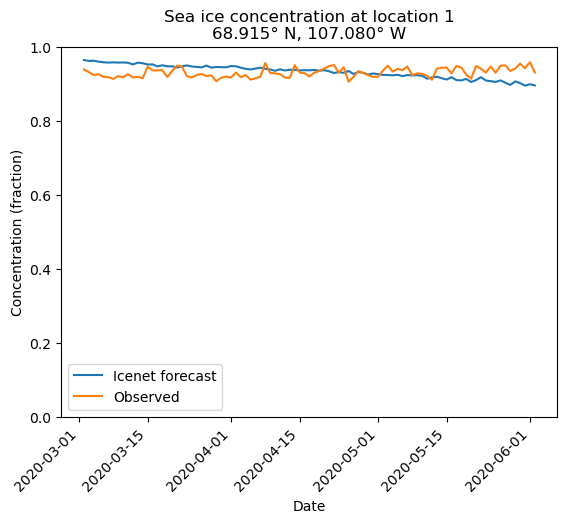

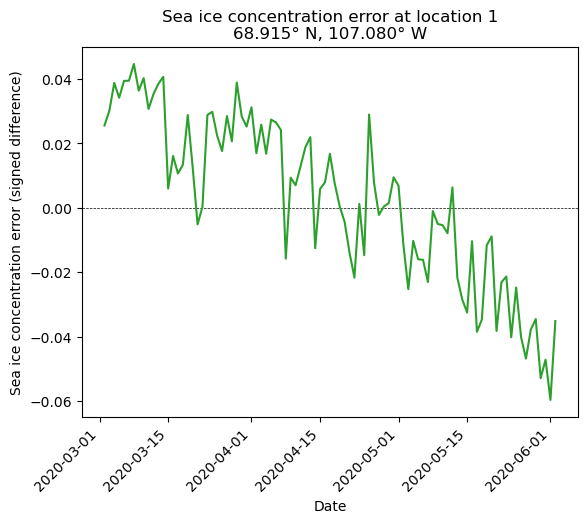

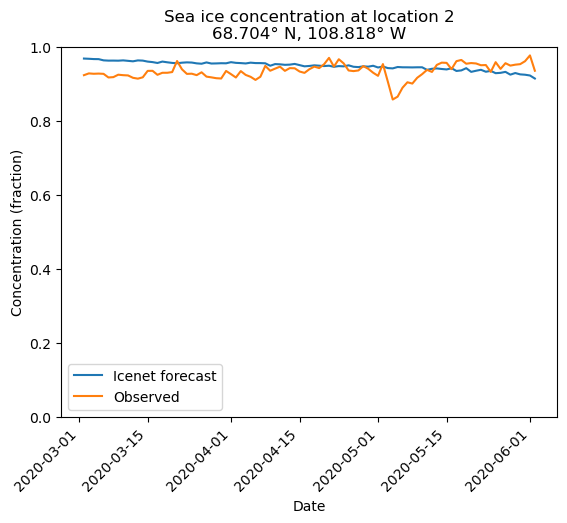

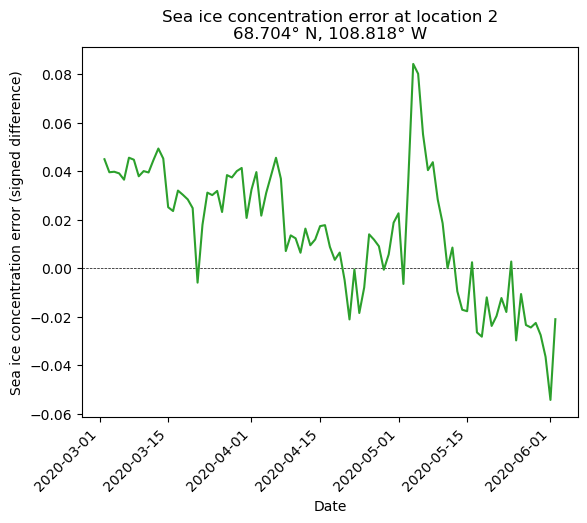

In [84]:
probes = np.array([[126, 188], [126, 185]])
fc_probes, obs_probes = process_probes(probes=probes, data=[fc, obs])
sic_error_local_plots(fc_da=fc_probes,
                      obs_da=obs_probes,
                      output_path=None)

Note that we could've accomplished the same task by using the `icenet_plot_sic_error_local` command:

In [77]:
!icenet_plot_sic_error_local -h

2023-03-14 18:56:23.634999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 18:56:23.791433: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: icenet_plot_sic_error_local [-h] [-o OUTPUT_PATH] [-v] [-r REGION]
                                   [-p LOCATION]
                                   {north,south} forecast_file forecast_date

positional arguments:
  {north,south}
  forecast_file
  forecast_date

optional arguments:
  -h, --help            show this help message and e

In [ ]:
!icenet_plot_sic_error_local north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" "2020-03-01"

### Metrics based on SIC error

In the above plot, we plotted the difference in SIC between the forecast made and the OSISAF data at a particular grid location (or "probe"). However, if we wanted to get an overall picture of how well the forecast performed over the entire region, we need to compute the error of the forecast at each grid location and summarise them in some way. Some examples of such methods are:
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

These are all standard metrics when modelling a continuous variable, and so we won't explain them in detail here.

To simply compute these metrics, we can use the `compute_metrics` function which takes in a list of the above metrics and returns a dictionary where the keys are the metric names and the values are the corresponding `xarray.DataArray` objects which stores the metric values for each leadtime.

In the below example, we compute MSE for each leadtime in the forecast.

In [85]:
fc_mse = compute_metrics(metrics=["MSE"],
                         masks=masks,
                         fc_da=fc,
                         obs_da=obs)
fc_mse

{'MSE': <xarray.DataArray (time: 93)>
 dask.array<truediv, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
     Lambert_Azimuthal_Grid  int32 -2147483647
     forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
   * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02}

We can access the individual metrics by using the `.values` attribute of the `xarray.DataArray` object.

In [86]:
fc_mse["MSE"].values

array([ 17.14572787,  25.49379145,  35.55724865,  43.18853152,
        39.85115982,  44.08913618,  57.52404127,  75.27063937,
       107.08665121, 124.18523222, 124.01354524, 140.09899944,
       133.07698687, 137.82353583, 145.15139229, 145.90736926,
       146.3868392 , 169.43993761, 186.17594205, 185.81365849,
       187.60769174, 198.86297095, 196.88927455, 214.08428404,
       220.91280572, 230.72525247, 227.90725778, 226.18730806,
       232.58887491, 240.77222474, 250.99954984, 254.73633222,
       260.33234598, 259.73620276, 269.78403897, 269.44424378,
       257.09733176, 237.17792096, 243.26331951, 262.09030902,
       273.64476692, 276.45799972, 275.57719521, 251.62616116,
       230.02736516, 218.67398126, 225.71589898, 211.64091227,
       214.77512022, 226.93483341, 233.10282695, 231.14606664,
       233.24510471, 236.52239507, 237.01420138, 233.88291562,
       227.29492084, 214.13856538, 205.31805786, 197.54652224,
       207.50292395, 219.77038864, 221.57004845, 209.54

Plotting the metrics is simply done by `plot_metrics` function, which again takes in a list of metrics that you wish to visualise. Here we plot the MSE at each leadtime of the forecast initialised at our date of interest.

INFO:root:Saving to plot/MSE.png


({'RMSE': <xarray.DataArray (time: 93)>
  dask.array<sqrt, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
  Coordinates:
      Lambert_Azimuthal_Grid  int32 -2147483647
      forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
    * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02},
 None)

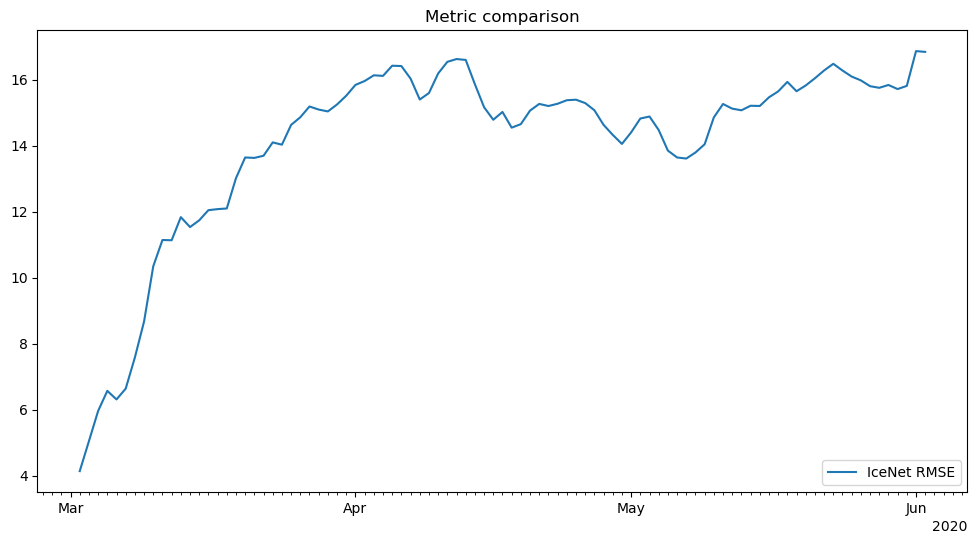

In [88]:
plot_metrics(metrics=["MSE"],
             masks=masks,
             fc_da=fc,
             obs_da=obs, 
             cmp_da=None,
             output_path="plot/MSE.png")

Note that this could also be achieved in the command line via the `icenet_plot_metrics` CLI:

In [89]:
!icenet_plot_metrics -h

2023-03-14 19:09:19.884028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 19:09:20.045871: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: icenet_plot_metrics [-h] [-o OUTPUT_PATH] [-v] [-r REGION] [-b] [-e]
                           [-m METRICS] [-s]
                           {north,south} forecast_file forecast_date

positional arguments:
  {north,south}
  forecast_file
  forecast_date

optional arguments:
  -h, --help            show this help message and exit
  -o O

In [ ]:
!icenet_plot_metric north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" "2020-03-01" \
    -o "plot/MSE.png" \
    -m "MSE"

Notice in our calls for `plot_metrics` and `compute_metrics`, we passed in `None` for the `cmp` argument. With the `cmp` argument, we can pass in a forecast to compare with. Here, we will compare with SEAS5, a dynamical model from the European Centre for Medium-Range Weather Forecasts (ECMWF).

To access these forecasts, we can use the `get_seas_forecast_da` function in the IceNet library, where we pass in the hemisphere we want the data for, the (initialisation) date of interest, and whether or not to apply bias correction (details of how this is performed can be found in Andersson et. al (2021)).

In [12]:
cmp = get_seas_forecast_da(hemisphere="north",
                           date=date_of_interest,
                           bias_correct=True)
cmp = cmp.assign_coords(dict(xc=cmp.xc / 1e3, yc=cmp.yc / 1e3))
cmp = cmp.isel(time=slice(1, None))

INFO:root:Got files: ['./data/osisaf/north/siconca/2010.nc', './data/osisaf/north/siconca/2011.nc', './data/osisaf/north/siconca/2012.nc', './data/osisaf/north/siconca/2013.nc', './data/osisaf/north/siconca/2014.nc', './data/osisaf/north/siconca/2015.nc', './data/osisaf/north/siconca/2016.nc', './data/osisaf/north/siconca/2017.nc', './data/osisaf/north/siconca/2018.nc', './data/osisaf/north/siconca/2019.nc', './data/osisaf/north/siconca/2020.nc', './data/osisaf/north/siconca/2021.nc', './data/osisaf/north/siconca/2022.nc', './data/osisaf/north/siconca/2023.nc']
INFO:root:Debiaser input ranges: obs 0.00 - 1.00, hist -0.00 - 1.00, fut 0.00 - 1.00
INFO:root:----- Running debiasing for variable: siconc -----
100%|██████████| 186624/186624 [00:12<00:00, 14396.71it/s]
INFO:root:Debiaser output range: -0.62 - 1.11
INFO:root:Returning SEAS data from ./data/mars.seas/north/siconca/20200301.nc from 2020-03-01 00:00:00


We now can pass this into the `plot_metrics` function, and here we plot the MAE and RMSE metrics.

INFO:root:Saving to plot/MAE_RMSE_comp.png


({'MAE': <xarray.DataArray (time: 93)>
  dask.array<truediv, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
  Coordinates:
      Lambert_Azimuthal_Grid  int32 -2147483647
      forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
    * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02,
  'RMSE': <xarray.DataArray (time: 93)>
  dask.array<sqrt, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
  Coordinates:
      Lambert_Azimuthal_Grid  int32 -2147483647
      forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
    * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02},
 {'MAE': <xarray.DataArray (time: 93)>
  dask.array<truediv, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
  Coordinates:
    * time     (time) datetime64[ns] 2020-03-02 2020-03-03 ... 2020-06-02,
  'RMSE': <xarray.DataArray (time: 93)>
  dask.array<sqrt, shape=(93,), dtype=

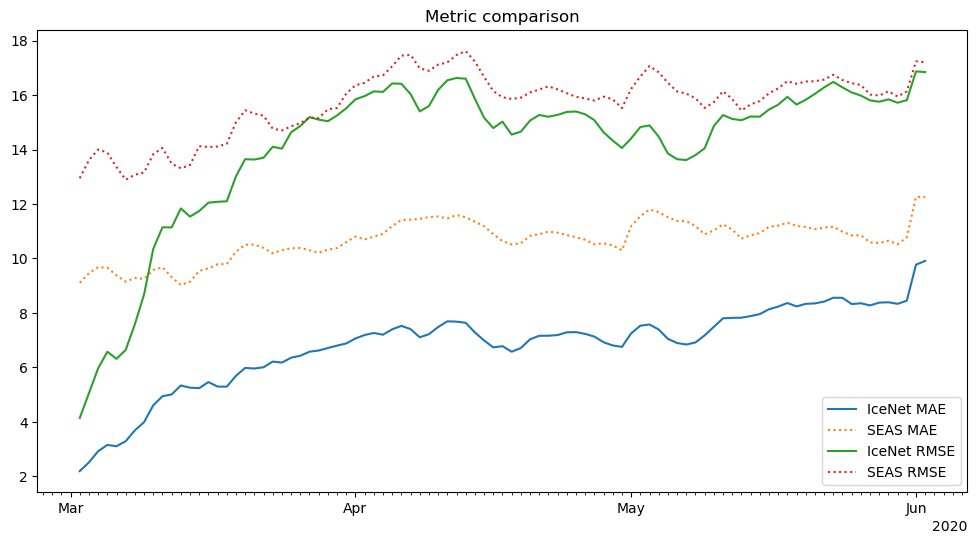

In [90]:
plot_metrics(metrics=["MAE", "RMSE"],
             masks=masks,
             fc_da=fc,
             obs_da=obs,
             cmp_da=cmp,
             output_path="plot/MAE_RMSE_comp.png")

To do this with the CLI, we use the `--ecmwf` (or `-e`) flag.

In [ ]:
!icenet_plot_metric north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" "2020-03-01" \
    -o "plot/MAE_RMSE_comp.png" \
    -m "MSE" \
    -e \
    -b

### Binary accuracy metric

In the original IceNet model presented in (citation), the problem of predicting SIC was framed as a classification task with the output SIC values divided into three classes:
- open-water: ($\text{SIC} \leq 15\%$)
- marginal ice: ($15\% < \text{SIC} < 80\%$)
- full ice: ($\text{SIC} \geq 80\%$)

A metric proposed in the paper was to look at the _sea-ice probability (SIP)_, defined as $P(\text{SIC} > 15\%)$ and obtained by summing the marginal ice probability, $P(15\% < \text{SIC} < 80\%)$ and full ice probability, $P(\text{SIC} \geq 80\%)$. It is noted in the paper that 15\% is the standard SIC threshold for defining ice-edge position. 

The _binary accuracy metric_ was obtained by looking at IceNet's probabilistic SIP outputs and mapping to a binary class prediction of ice if $(\text{SIP} > 0.5)$ and open-water if $(\text{SIP} \leq 0.5)$. We do this with the OSISAF data and look at the accuracy of this task.

However, the current IceNet model predicts SIC directly, and so we slightly tweak how we compute this metric. In particular, we simply map our continuous SIC forecasts into a binary class prediction of ice if we predict $(\text{SIC} > 15\%)$ and open-water if we predict $(\text{SIC} \leq 15\%)$. We do this with the OSISAF data and look at the accuracy of this task.

To do this in Python, we simply use the `compute_binary_accuracy` function, where we have to pass in the threshold that we want to compare at - typically, this will be 15\%, but in other settings, we may want to look at different thresholds.

In [14]:
fc_binacc = compute_binary_accuracy(masks=masks,
                                    fc_da=fc,
                                    obs_da=obs,
                                    threshold=0.15)
fc_binacc

<xarray.DataArray (time: 93)>
dask.array<mul, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
Coordinates:
    Lambert_Azimuthal_Grid  int32 -2147483647
    forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
  * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02

In [15]:
fc_binacc.values

array([98.98083494, 98.79067003, 98.41034022, 98.22017531, 98.31525776,
       98.0300104 , 97.83984549, 97.22180954, 96.88902095, 96.55623236,
       96.36606745, 95.79557272, 95.65294904, 95.36770168, 95.32016045,
       95.41524291, 95.51032536, 95.08245432, 94.65458327, 94.65458327,
       94.60704204, 94.32179468, 94.36933591, 93.98900609, 93.70375873,
       93.56113505, 93.70375873, 93.75129996, 93.84638241, 93.6562175 ,
       93.49212077, 93.58835559, 93.34776856, 92.9628293 , 92.52977265,
       92.57789005, 92.86659449, 93.01094671, 92.9147119 , 92.72224227,
       92.62600746, 92.67412486, 92.81847708, 93.34776856, 93.6845904 ,
       93.92517743, 93.6845904 , 93.92517743, 93.97329484, 93.58835559,
       93.58835559, 93.6845904 , 93.49212077, 93.58835559, 93.6845904 ,
       93.73270781, 93.58835559, 93.78082521, 93.92517743, 93.97329484,
       93.73233259, 93.47239822, 93.36842447, 93.62835884, 93.88829321,
       94.04425383, 94.0962407 , 93.99226695, 93.88829321, 93.42

To plot, we can use the `plot_binary_accuracy` function in a similar way:

INFO:root:Saving to plot/binacc_comp.png


(<xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
     Lambert_Azimuthal_Grid  int32 -2147483647
     forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
   * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02,
 <xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) datetime64[ns] 2020-03-02 2020-03-03 ... 2020-06-02)

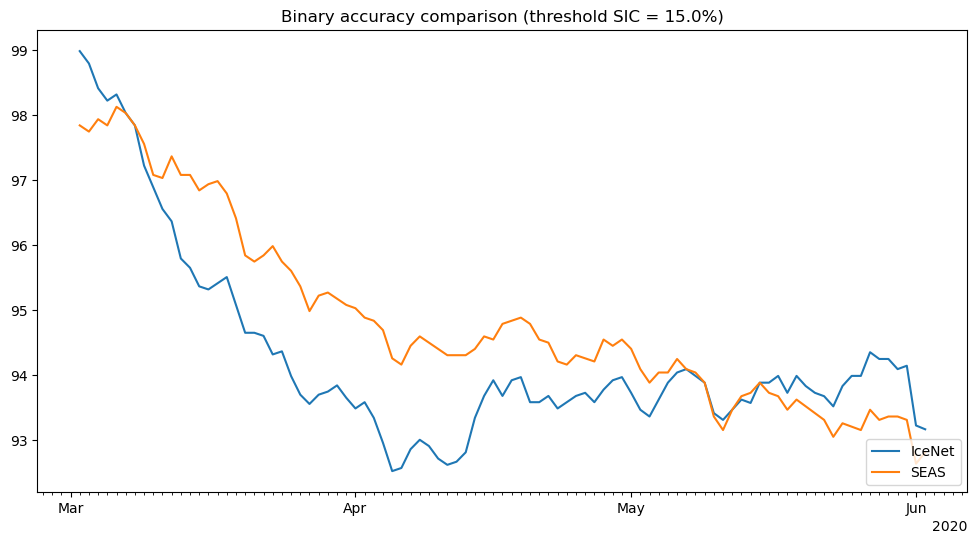

In [17]:
plot_binary_accuracy(masks=masks,
                     fc_da=fc,
                     obs_da=obs,
                     cmp_da=cmp,
                     output_path="plot/binacc_comp.png")

Note that we can accomplish this via the `icenet_plot_bin_accuracy` CLI:

In [82]:
!icenet_plot_bin_accuracy -h

2023-03-14 18:59:20.823844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 18:59:20.994394: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: icenet_plot_bin_accuracy [-h] [-o OUTPUT_PATH] [-v] [-r REGION] [-b]
                                [-e] [-t THRESHOLD]
                                {north,south} forecast_file forecast_date

positional arguments:
  {north,south}
  forecast_file
  forecast_date

optional arguments:
  -h, --help            show this help message and

Note that we can specify the SIC threshold of interest with `--threshold` (or `-t`), but if this is not specified, we simply use 15\%.

In [ ]:
!icenet_plot_bin_accuracy north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" "2020-03-01" \
    -o "plot/binacc_comp.png" \
    -e \
    -b

### Sea-ice extent metric

Another common metric used in sea ice analysis (and is used in the Andersson et. al (2021) too) is _sea ice extent (SIE)_ which is defined as the total area covered by grid cells with $(\text{SIC} > 15\%)$. The _SIE error_ therefore is the (signed) difference between the total area of grid cells with $(\text{SIC} > 15\%)$ in our forecast and in the OSISAF data. We can compute this simply with the `compute_sea_ice_extent_error`. With this function, we must pass in the grid area size (OSISAF has $25km^{2}$ resolution, so we pass in $25$ here) and we must specify the threshold we're interested - again, we're typically interested in 15\%, but we may be interested in different thresholds.

In [18]:
fc_sie = compute_sea_ice_extent_error(masks=masks,
                                      fc_da=fc,
                                      obs_da=obs,
                                      grid_area_size=25,
                                      threshold=0.15)
fc_sie

<xarray.DataArray (time: 93)>
dask.array<mul, shape=(93,), dtype=int64, chunksize=(93,), chunktype=numpy.ndarray>
Coordinates:
    Lambert_Azimuthal_Grid  int32 -2147483647
    forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
  * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02

In [19]:
fc_sie.values

array([  76875,   43750,   96250,  135625,  176250,  165000,  151250,
        148125,  103750,  200000,  216875,  242500,  243750,  237500,
        273750,  261250,  281875,  251875,  321250,  453125,  478125,
        515000,  586875,  703125,  711875,  817500,  807500,  766250,
        746875,  799375,  823125,  814375,  927500, 1003125, 1061875,
       1020000,  990000, 1040000,  999375,  990625, 1023125,  948750,
        946875,  917500,  883125,  853125,  925625,  845000,  805625,
        796250,  764375,  726875,  731875,  755625,  748750,  700000,
        696875,  616875,  558125,  542500,  520625,  521250,  539375,
        541250,  540625,  554375,  560000,  595625,  608125,  677500,
        688750,  681875,  739375,  760625,  758750,  784375,  801875,
        843750,  801250,  771250,  836250,  820625,  833750,  799375,
        739375,  684375,  668750,  641875,  686250,  675000,  718750,
        720000,  733125])

We can plot this data with `plot_sea_ice_extent_error`:

INFO:root:Saving to plot/SIE_comp.png


(<xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=int64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
     Lambert_Azimuthal_Grid  int32 -2147483647
     forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
   * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02,
 <xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=int64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) datetime64[ns] 2020-03-02 2020-03-03 ... 2020-06-02)

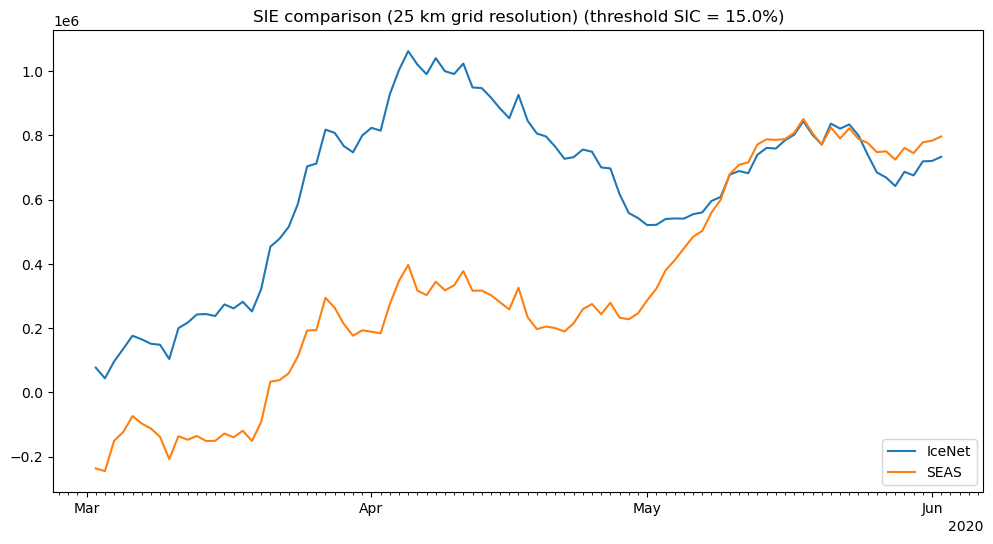

In [20]:
plot_sea_ice_extent_error(masks=masks,
                          fc_da=fc,
                          obs_da=obs,
                          cmp_da=cmp,
                          output_path="plot/SIE_comp.png")

We can do the same with the `icenet_plot_sie_error` CLI:

In [2]:
!icenet_plot_sie_error -h

2023-03-15 14:07:35.359968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 14:07:35.950218: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: icenet_plot_sie_error [-h] [-o OUTPUT_PATH] [-v] [-r REGION] [-b] [-e]
                             [-t THRESHOLD] [-ga GRID_AREA]
                             {north,south} forecast_file forecast_date

positional arguments:
  {north,south}
  forecast_file
  forecast_date

optional arguments:
  -h, --help            show this help mess

Note that we can specify the SIC threshold of interest with `--threshold` (or `-t`), but as with the binary accuracy metric, if this is not specified, we simply use 15\%. We can also specify the length of the sides used in the grid-area resolution size (in km), with `--grid-area` (of `-g`), but if this is not specified, this will be set to 25.

In [ ]:
!icenet_plot_sie_error north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" "2020-03-01" \
    -o "plot/binaSIE_compcc_comp.png" \
    -e \
    -b

## Leadtime averaged metrics and plots

In the previous set of commands and functions, we looked at a particular date where the model was initialised at (2020-03-01), and evaluated metrics to determine how good or bad the IceNet prediction was at each leadtime. While this is useful is we're interested in a evaluating our predictions made at a particular date, but we may be interested in how well the model has performed on average at different leadtimes. Here we look at how we can make plots to average over leadtimes.

Before computing the average performance of the model at different leadtimes, we must compute our metric of interest for each leadtime, for each initialisation date in our forecast file. We can do this with the `compute_metrics_leadtime_avg` function in the IceNet library.

Here, we specify what metric we're interested in (here, we'll look at RMSE), the masks, the hemisphere we're working in, the forecast file we want to compute metrics for, whether or not we're going to compare with SEAS5, and where to save our metrics dataframe. This dataframe stores the initialisation date of the forecast (along with the day of year it is, and what month that date is in), the target date of the forecast (i.e. the initialisation date + the leadtime), the leadtime, and the metric name.

We can then use this dataframe to average over the leadtime in a number of ways.

In [21]:
rmse_leadtime_avg_df = compute_metrics_leadtime_avg(metric="RMSE",
                                                      masks=masks,
                                                      hemisphere="north",
                                                      forecast_file=forecast_file,
                                                      emcwf=False,
                                                      data_path="metrics/RMSE_leadtime_avg.csv")

In [22]:
rmse_leadtime_avg_df

,Unnamed: 0,date,dayofyear,month,target_date,target_dayofyear,target_month,leadtime,RMSE,forecast_name
0,0,2018-01-01,1,1,2018-01-02,2,1,1,4.234488,IceNet
1,1,2018-01-01,1,1,2018-01-03,3,1,2,5.147462,IceNet
2,2,2018-01-01,1,1,2018-01-04,4,1,3,6.004297,IceNet
3,3,2018-01-01,1,1,2018-01-05,5,1,4,6.562929,IceNet
4,4,2018-01-01,1,1,2018-01-06,6,1,5,7.107866,IceNet
...,...,...,...,...,...,...,...,...,...,...
101923,88,2020-12-31,365,12,2021-03-30,89,3,89,12.237754,IceNet
101924,89,2020-12-31,365,12,2021-03-31,90,3,90,11.812640,IceNet
101925,90,2020-12-31,365,12,2021-04-01,91,4,91,11.725054,IceNet
101926,91,2020-12-31,365,12,2021-04-02,92,4,92,12.121185,IceNet


To plot leadtime averaged metrics, we use the `plot_metrics_leadtime_avg`.

There are several ways we can average over leadtime. The most simple way is to average over all of the forecasts, which we can then produce a line graph for where we have the average performance of the model at each of the leadtimes. To make this plot, we specify `average_over="all"` in the function, and we also pass in the path to the data (in the above, we saved this metrics dataframe to `metrics/RMSE_leadtime_avg.csv`).

Note that when `data_path` is specified, `plot_metrics_leadtime_avg` will _attempt_ to load in the metrics data frame, but if this does not exist, the function will call `compute_metrics_leadtime_avg` and compute the metrics data frame and save it in that location. So in general, `compute_metrics_leadtime_avg` does not need to be called prior to using `plot_metrics_leadtime_avg`, as it will be called if necessary. The advantage of this is that we can produce many different plots using this data without needing to recompute it - and for large forecast files with many initialisation dates, this can be quite costly.

INFO:root:Attempting to read in metrics dataframe from metrics/RMSE_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for RMSE metric
INFO:root:Saving to plot/RMSE_leadtime_avg_all.png


(        Unnamed: 0       date  dayofyear  month target_date  target_dayofyear  \
 0                0 2018-01-01          1      1  2018-01-02                 2   
 1                1 2018-01-01          1      1  2018-01-03                 3   
 2                2 2018-01-01          1      1  2018-01-04                 4   
 3                3 2018-01-01          1      1  2018-01-05                 5   
 4                4 2018-01-01          1      1  2018-01-06                 6   
 ...            ...        ...        ...    ...         ...               ...   
 101923          88 2020-12-31        365     12  2021-03-30                89   
 101924          89 2020-12-31        365     12  2021-03-31                90   
 101925          90 2020-12-31        365     12  2021-04-01                91   
 101926          91 2020-12-31        365     12  2021-04-02                92   
 101927          92 2020-12-31        365     12  2021-04-03                93   
 
         targe

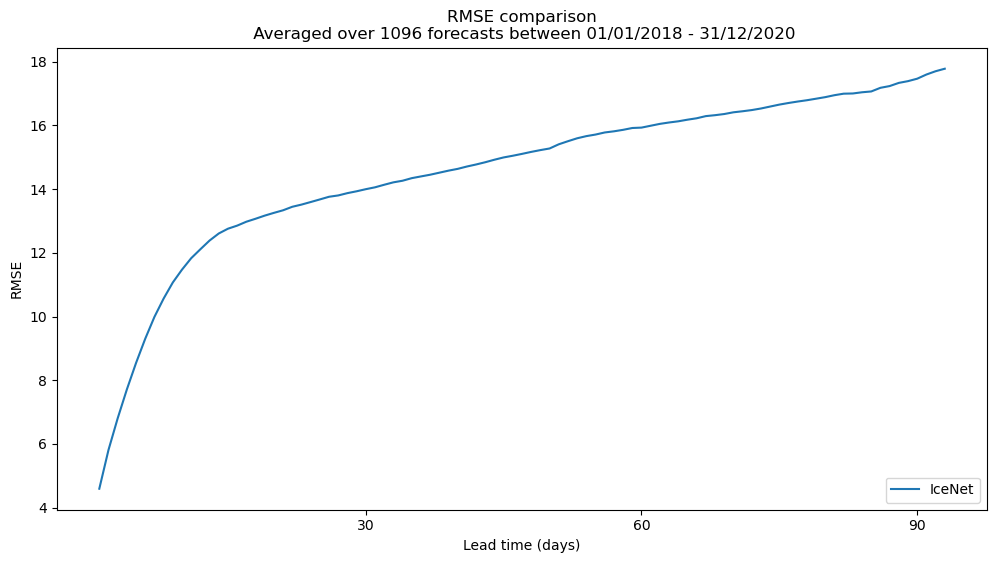

In [39]:
plot_metrics_leadtime_avg(metric="RMSE",
                          masks=masks,
                          hemisphere="north",
                          forecast_file=forecast_file,
                          emcwf=False,
                          output_path="plot/RMSE_leadtime_avg_all.png",
                          average_over="all",
                          data_path="metrics/RMSE_leadtime_avg.csv")

In the above plot, we can see in the title that we have averaged over _ forecasts, and this gives us an idea of how well our model performs at each leadtime on average over this time period (more specifically how well it performed on average in the forecasts in the forecast file provided).

We can also do all of the above with the `icenet_plot_leadtime_avg` CLI:

In [25]:
!icenet_plot_leadtime_avg -h

2023-03-14 10:45:36.365293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 10:45:36.524971: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: icenet_plot_leadtime_avg [-h] [-o OUTPUT_PATH] [-v] [-r REGION] [-b]
                                [-e] [-m METRIC] [-dp DATA_PATH]
                                [-ao {all,month,day}] [-td]
                                {north,south} forecast_file

positional arguments:
  {north,south}
  forecast_file

optional arguments:
  -h, -

Notice in the above documentation that there are several arguments. In the `--average_over` (or `-ao`) argument, we specify how we want to average over the forecasts available. In the above plot, we simply averaged over all forecasts available (by setting this to be `"all"`), but we may be interested in averaging over month (which can tell us how well our model does on average in particular months of the year), and over the day (which can tell us how well our model does on average on particular days of the year).

Let's have a look at what averaging over month looks like:

In [41]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc" \
    -m "RMSE" \
    -dp "metrics/RMSE_leadtime_avg.csv" \
    -ao "month"

2023-03-14 16:59:02.835177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 16:59:03.021000: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/RMSE_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for RMSE metric
INFO:root:Saving to plot/leadtime_averaged_init_month_RMSE.png


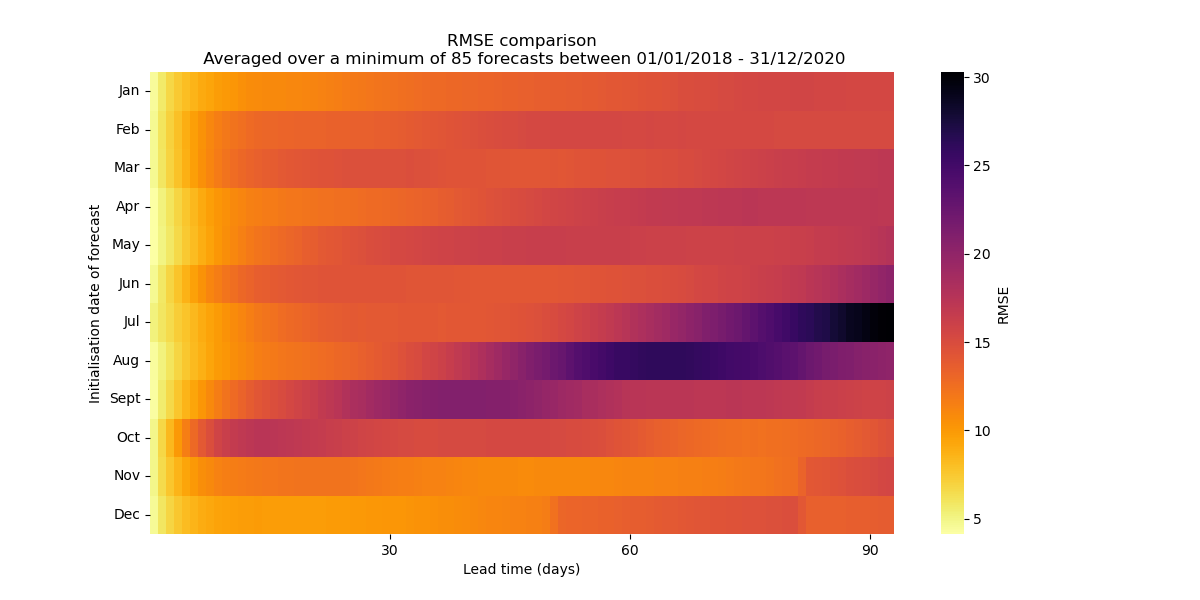

In [42]:
Image("plot/leadtime_averaged_init_month_RMSE.png")

Let's have a look at averaging over day:

In [43]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" \
    -m "RMSE" \
    -dp "metrics/RMSE_leadtime_avg.csv" \
    -ao "day"

2023-03-14 16:59:39.369064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 16:59:39.570671: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/RMSE_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for RMSE metric
INFO:root:Saving to plot/leadtime_averaged_init_day_RMSE.png


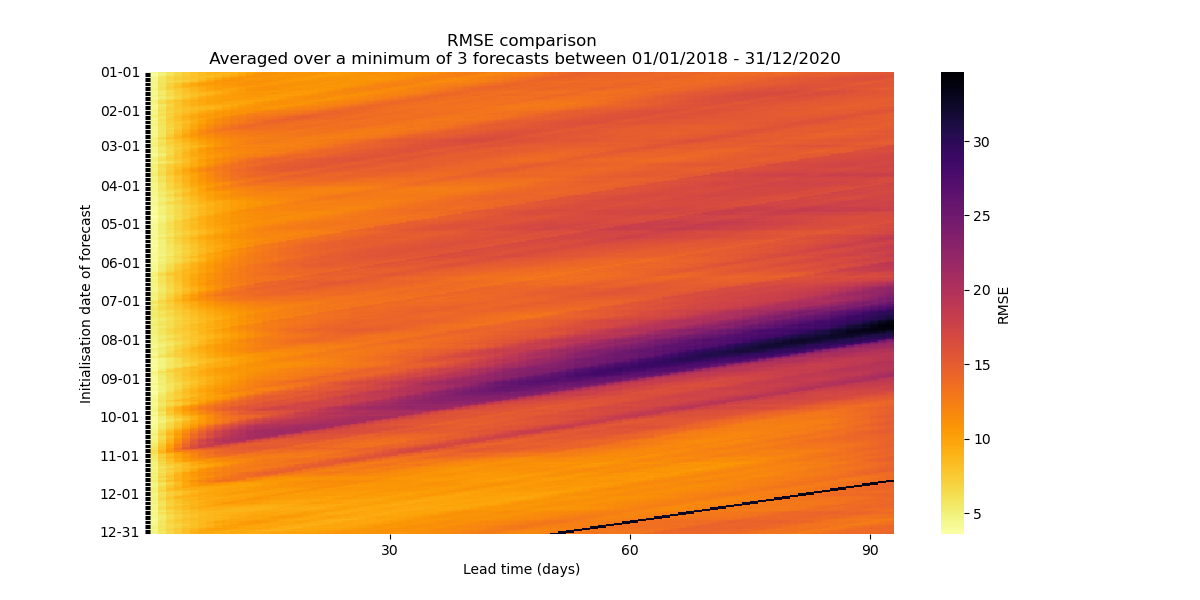

In [44]:
Image("plot/leadtime_averaged_init_day_RMSE.png")

Another interesting option in the `icenet_plot_leadtime_avg` CLI is the `--target_day` flag (or `-td`). If included, instead of having the _initialisation_ date of the forecast on the y-axis, we can have the `target` date of the forecast (i.e. the actual day that IceNet is predicting SIC for).

Let's average over day and look at the target day of forecast:

In [45]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" \
    -m "RMSE" \
    -dp "metrics/RMSE_leadtime_avg.csv" \
    -ao "day" \
    -td

2023-03-14 16:59:46.549105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 16:59:46.718295: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/RMSE_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for RMSE metric
INFO:root:Saving to plot/leadtime_averaged_target_day_RMSE.png


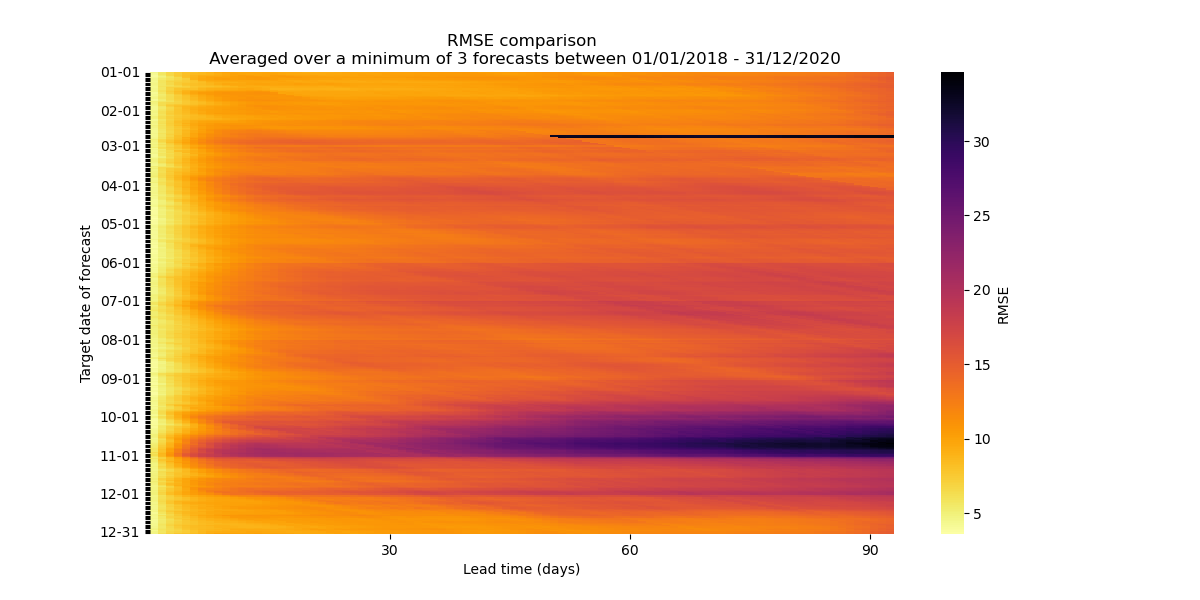

In [46]:
Image("plot/leadtime_averaged_target_day_RMSE.png")

As with our previous commands, we can also compare with SEAS5 by simply using the `--ecmwf` (or `-e`) flag:

In [91]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" \
    -m "RMSE" \
    -dp "metrics/RMSE_leadtime_avg_comp.csv" \
    -ao "all" \
    -e

2023-03-14 19:10:14.006208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 19:10:14.161826: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/RMSE_leadtime_avg_comp.csv
INFO:root:Creating leadtime averaged plot for RMSE metric
INFO:root:Saving to plot/leadtime_averaged_init_all_RMSE_comp.png


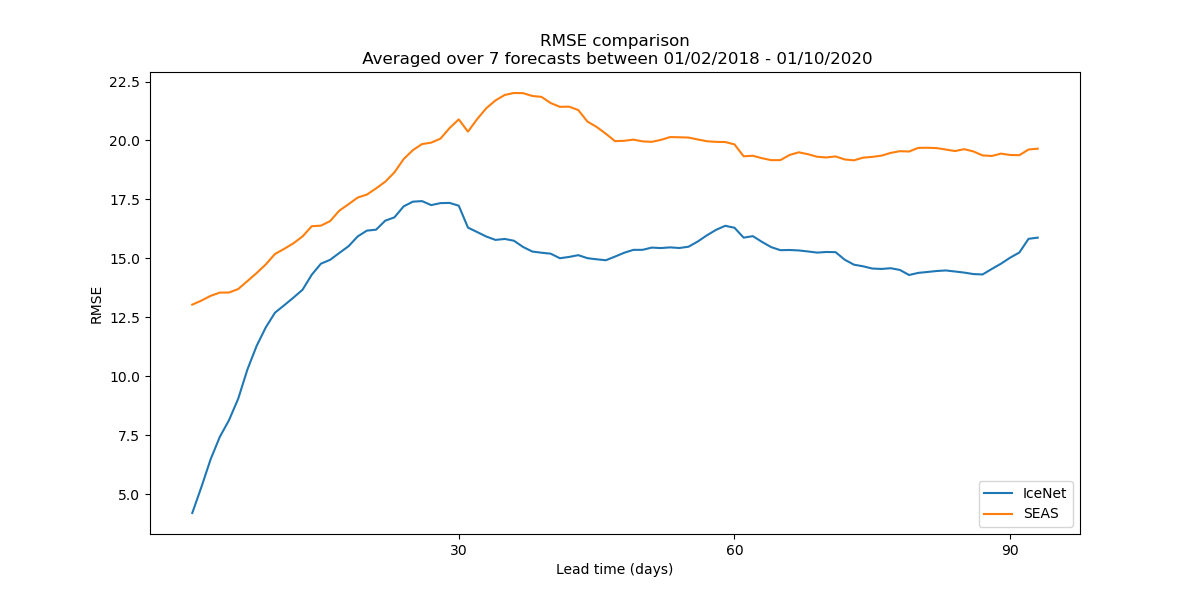

In [92]:
Image("plot/leadtime_averaged_init_all_RMSE_comp.png")

Note that we'll typically average over fewer forecasts, as we will not always have the corresponding SEAS5 forecast with the same initialisation date.

Similarly, we can look at averaging over the months and compare. This produces a plot with a different colour scale, were we're not highlighting the _difference_ in average metric performance between the models.

In [48]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" \
    -m "RMSE" \
    -dp "metrics/RMSE_leadtime_avg_comp.csv" \
    -ao "month" \
    -e

2023-03-14 17:00:25.036838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 17:00:25.206746: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/RMSE_leadtime_avg_comp.csv
INFO:root:Creating leadtime averaged plot for RMSE metric
INFO:root:Saving to plot/leadtime_averaged_init_month_RMSE_comp.png


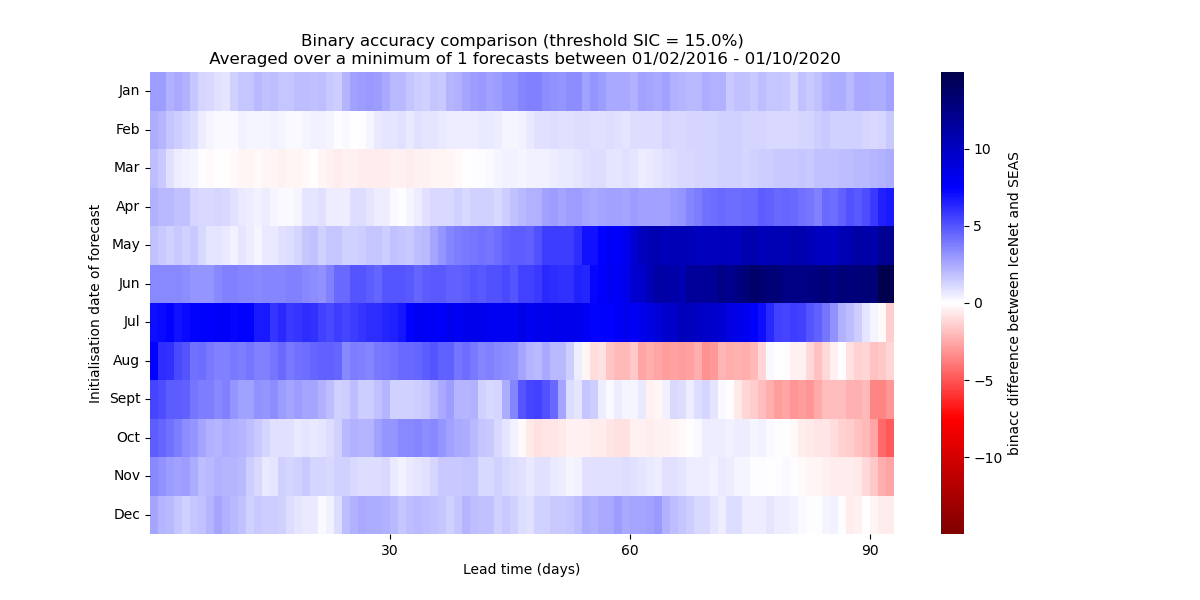

In [35]:
Image("plot/leadtime_averaged_init_month_RMSE_comp.png")